In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV        # feature selection
from sklearn.linear_model import LogisticRegression  # models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV #parameter search
from sklearn.model_selection import train_test_split # oversampling and splitting data
from sklearn.preprocessing import MinMaxScaler   # scaling the data
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE 
from sklearn.metrics import roc_auc_score           #metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import export_graphviz      # pretty plots
from subprocess import call
from IPython.display import Image
from PIL import Image
#set random seed
# np.random.seed(8)

Image.MAX_IMAGE_PIXELS = 933120000

# run the model with less features to try to get rid of overfitting!!!!!!!!!!!!
# read about the features again and look over the paper

In [34]:
full_data = pd.read_csv('csv/all_feats_all_tasks_non_slimmed.csv')
speech_col_names = [x for x in list(full_data.columns) if 'vad' in x]
speech_col_names = speech_col_names + ['childid']
speech_ds = full_data[speech_col_names]
bubbles_col_names = [y for y in list(full_data.columns) if 'bubbles' in y]
bubbles_col_names = bubbles_col_names + ['childid']
bubbles_ds = full_data[bubbles_col_names] # dataframe of all bubbles features
appr_col_names = [z for z in list(full_data.columns) if 'list' in z]
appr_col_names = appr_col_names + ['childid']
appr_ds = full_data[appr_col_names] # dataframe of all approach features 
speech_ds = speech_ds.set_index('childid')
bubbles_ds = bubbles_ds.set_index('childid')
appr_ds = appr_ds.set_index('childid')
full_data = full_data.set_index('childid')

kiddos = pd.read_csv('csv/target_information.csv')
kiddos['adhd_count'] = kiddos['adhddxever']>0
kiddos.adhd_count = kiddos.adhd_count.replace({True: 1, False: 0})

col_names = ['childid','depdxever','anxdxever','adhd_count']
kiddos_ds = kiddos[col_names]
kiddos_ds = kiddos_ds.set_index('childid')
full_speech_ds = pd.concat([speech_ds,kiddos_ds],axis = 1)
full_bubbles_ds = pd.concat([bubbles_ds,kiddos_ds],axis = 1) 
full_appr_ds = pd.concat([appr_ds,kiddos_ds],axis = 1) 
full_ds = pd.concat([full_data,kiddos_ds],axis = 1) 

training = full_appr_ds.iloc[:,:-3]
# print(list(training))
# kiddos
# training

In [35]:
def oversampling(training:pd.DataFrame, target: pd.DataFrame): # to go back to normal, change training to X_res and y_res
    ros = SMOTE() 
    X_res, y_res = ros.fit_resample(training, target)
    X_res_scaled = MinMaxScaler().fit_transform(X_res)
    X_res = pd.DataFrame(X_res_scaled,columns = X_res.columns, index = X_res.index)
#     print(X_res)
    return X_res, y_res

def feature_selection(model, X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, num_feats: int, cv: int):
    selector = RFECV(model,step = 2, cv = cv, 
#                      min_features_to_select = num_feats,
                     scoring ='accuracy')
    selector = selector.fit(X_train, y_train)
#     order = selector.ranking_
    order = selector.get_feature_names_out(X_train.columns)
    dep_feats = []
    for i in order:
        dep_feats.append(i)
    if len(dep_feats) > num_feats:
        cols = dep_feats[:num_feats]
    else:
        cols = dep_feats
#     print(cols)
    training = X_train[cols]
    test = X_test[cols]
    return training, test

def searchin(mod, cv_grid: dict,X_train: pd.DataFrame, y_train: pd.DataFrame, cv: int):
    grid_clf = GridSearchCV(estimator=mod, 
                                param_grid=cv_grid,
                                scoring="accuracy",
                                cv=cv,
                           )
    grid_clf.fit(X_train.values, y_train.values)
    best_mod = grid_clf.best_estimator_
    best_mod.fit(X_train.values, y_train.values)
    if 'SVC' in str(mod):
        best_mod = mod.fit(X_train.values, y_train.values)
    print(best_mod)
    return best_mod

def metrics(mod,X_test: pd.DataFrame,y_test: pd.DataFrame, mod_str:str, sx:str):
    
    mod_sx_str = str(mod_str[:-2]+'_'+sx).lower()
    preds = mod.predict(X_test)
    probs = mod.predict_proba(X_test)
    
    acc = accuracy_score(y_true= y_test, y_pred= preds)
    print('Accuracy: ', acc)
    
    roc = roc_auc_score(y_test, probs[:,1]) 
    print('The ROC AUC: ', roc)
    
#     try: 
#         importances = mod.feature_importances_
#         for feature, importance in zip(X_test.columns, importances):
#             print(feature, importance)
#     except AttributeError:
#         print()
    
    try:
        estimator = mod.estimators_[1]

        export_graphviz(estimator, out_file= mod_sx_str+'.dot', 
                        feature_names = X_test.columns,
                        class_names = ['0','1'],
                        rounded = True, proportion = False, 
                        precision = 2, filled = True)

        call(['dot', '-Tpng', mod_sx_str+'.dot', '-o', mod_sx_str+'.png', '-Gdpi=600'])

#         Image(filename = mod_sx_str+'.png')
        pics = Image.open(mod_sx_str+'.png')
        pics = pics.resize((1080,1080),Image.ANTIALIAS)
        pics.save('pics/'+mod_sx_str+'.png', optimize=True, quality=95)  

    except AttributeError:
        print()
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
            confusion_matrix(y_test, preds),
        )

    cmp.plot(ax=ax)
    plt.show()
    return acc, roc

In [36]:
def multi_model(training: pd.DataFrame, target: pd.DataFrame, num_feats: int, cv:int, sx:str ):
    
    training, target = oversampling(training,target)

    X_train , X_test , y_train , y_test = train_test_split(training, target)
    acc_nums = []
    roc_nums = []
    
    cv_grid_lg = {
                "penalty": ["l2",'none'], #  'elasticnet','l1']
                'max_iter': np.arange(0, 10000,1000),
                'solver' : ['sag'], #,'liblinear' , 'saga']
            }
    cv_grid_rf = { 
                'n_estimators' : np.arange(50,150,10),
                'max_features' : ['log2','sqrt'], #,'auto'],
                'criterion' : ['entropy'],
                'max_depth': np.arange(1,20,2)
                }
    cv_grid_et = {
                'n_estimators' : np.arange(50,150,10),
                'max_features' : ['log2','sqrt'], #,'auto'],
                'criterion' : ['entropy'],
                'max_depth': np.arange(1,20,2)
                }

    cv_grid_mlp = {
                'hidden_layer_sizes': [(100,2), (100,3), (100,4), (100,5), (100,6)],
                'activation' : ['identity', 'logistic', 'tanh'], #, 'relu'],
                'solver' : ['sgd'], # adam],
                'learning_rate': ['adaptive'], # 'constant', 'invscaling']
                'max_iter' : np.arange(200,600,50),
                }
    cv_grid_svm = {
                'kernel' : ['rbf', 'sigmoid'],
                'degree' : np.arange(3,300),
                }

    mod = LogisticRegression()
    lr_str = str(mod)
    dep_train_lg, dep_test_lg = feature_selection(mod,X_train,y_train,X_test,num_feats,cv)
    model = searchin(mod,cv_grid_lg,dep_train_lg,y_train,cv)
    lg_acc, lg_roc = metrics(model,dep_test_lg, y_test, lr_str, sx)
    acc_nums.append(lg_acc)
    roc_nums.append(lg_roc)
    
    mod = RandomForestClassifier()
    rf_str = str(mod)
    dep_train_rf, dep_test_rf = feature_selection(mod,X_train,y_train,X_test,num_feats,cv)
    model = searchin(mod,cv_grid_rf,dep_train_rf,y_train,cv)
    rf_acc, rf_roc = metrics(model,dep_test_rf,y_test, rf_str,sx)
    acc_nums.append(rf_acc)
    roc_nums.append(rf_roc)
    
    mod = ExtraTreesClassifier()
    et_str = str(mod)
    dep_train_et, dep_test_et = feature_selection(mod,X_train,y_train,X_test,num_feats,cv)
    model = searchin(mod,cv_grid_et,dep_train_et,y_train,cv)
    et_acc, et_roc = metrics(model,dep_test_et, y_test, et_str, sx)
    acc_nums.append(et_acc)
    roc_nums.append(et_roc)
    
    mod = MLPClassifier(early_stopping = True)
    mlp_str = str(mod)
    # dep_train_nn, dep_test_nn = feature_selection(mod,X_train,y_train,X_test,30)
    model = searchin(mod,cv_grid_mlp,X_train,y_train,cv)
    nn_acc, nn_roc = metrics(model,X_test, y_test, mlp_str, sx)
    acc_nums.append(nn_acc)
    roc_nums.append(nn_roc)

    mod = SVC(probability = True)
    svm_str = str(mod)
#     dep_train_svm, dep_test_svm = feature_selection(mod,X_train,y_train,X_test,num_feats,cv)
    model = searchin(mod,cv_grid_svm,X_train,y_train,cv)
    svm_acc, svm_roc = metrics(mod,X_test, y_test,svm_str, sx)
    acc_nums.append(svm_acc)
    roc_nums.append(svm_roc)
    
    data = {sx+'_model_acc': acc_nums,
            sx+'_roc_auc': roc_nums}
    
    results = pd.DataFrame(index = ['logistic', 'random forest', 'extra trees', 'MLP NN', 'SVM'], data = data)
    
    return results

C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

LogisticRegression(max_iter=6000, penalty='none', solver='sag')
Accuracy:  0.8108108108108109
The ROC AUC:  0.9642857142857143



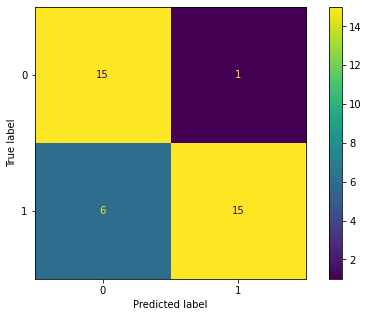

RandomForestClassifier(criterion='entropy', max_depth=19, max_features='sqrt',
                       n_estimators=130)
Accuracy:  0.972972972972973
The ROC AUC:  0.9955357142857143


C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


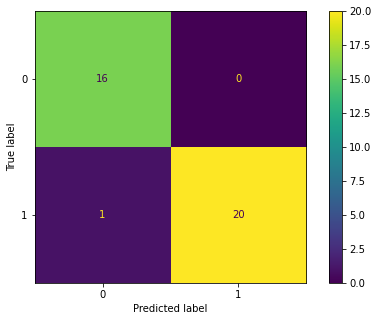

ExtraTreesClassifier(criterion='entropy', max_depth=19, max_features='sqrt',
                     n_estimators=120)
Accuracy:  0.972972972972973
The ROC AUC:  1.0


C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


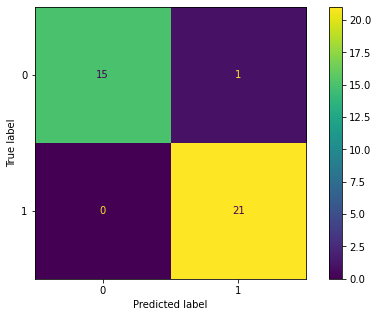

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(100, 4), learning_rate='adaptive',
              max_iter=400, solver='sgd')
Accuracy:  0.5675675675675675
The ROC AUC:  0.7559523809523809



C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


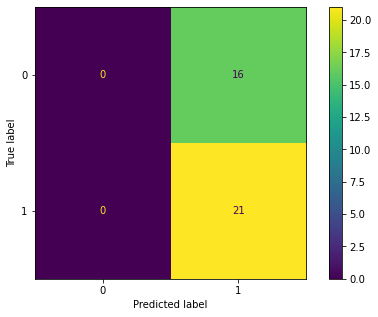

SVC(probability=True)
Accuracy:  0.7027027027027027
The ROC AUC:  0.9107142857142857



C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


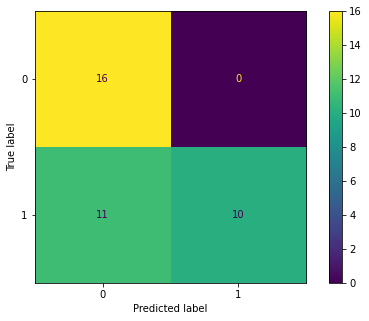

C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

LogisticRegression(max_iter=1000, penalty='none', solver='sag')
Accuracy:  0.6296296296296297
The ROC AUC:  0.7117647058823529



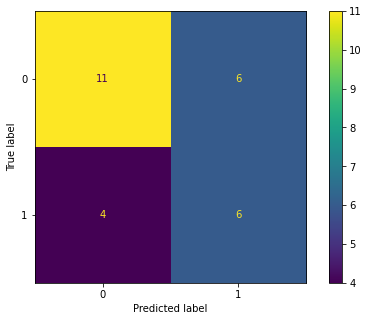

RandomForestClassifier(criterion='entropy', max_depth=17, max_features='log2',
                       n_estimators=60)
Accuracy:  0.7777777777777778
The ROC AUC:  0.8647058823529412


C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


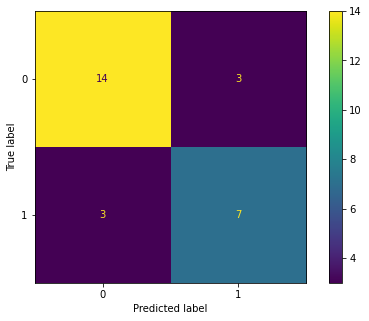

ExtraTreesClassifier(criterion='entropy', max_depth=13, max_features='sqrt')
Accuracy:  0.8148148148148148
The ROC AUC:  0.9352941176470588


C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


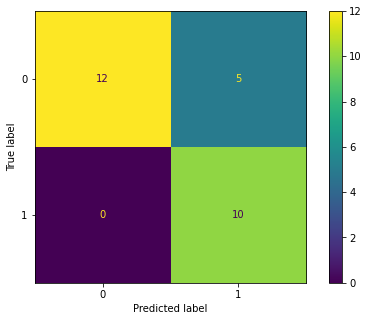

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(100, 3), learning_rate='adaptive',
              max_iter=350, solver='sgd')
Accuracy:  0.6296296296296297
The ROC AUC:  0.5470588235294118



C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


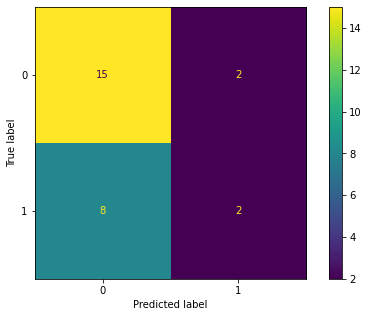

SVC(probability=True)
Accuracy:  0.5185185185185185
The ROC AUC:  0.6705882352941177



C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


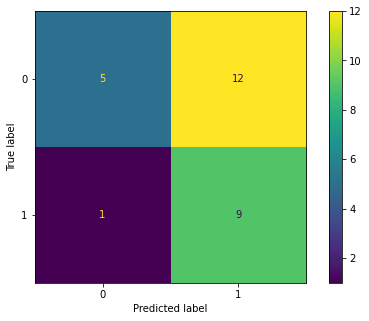

C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

LogisticRegression(max_iter=2000, penalty='none', solver='sag')
Accuracy:  0.7647058823529411
The ROC AUC:  0.7859649122807018



C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


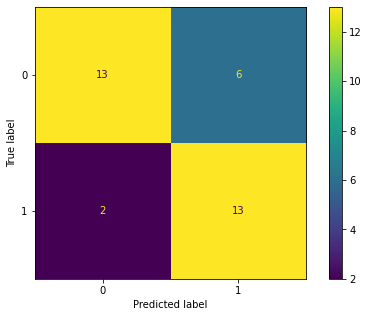

RandomForestClassifier(criterion='entropy', max_depth=9, max_features='log2',
                       n_estimators=60)
Accuracy:  0.7941176470588235
The ROC AUC:  0.8947368421052632


C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


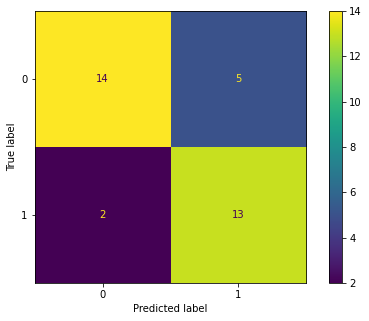

ExtraTreesClassifier(criterion='entropy', max_depth=17, max_features='sqrt',
                     n_estimators=70)
Accuracy:  0.8235294117647058
The ROC AUC:  0.9350877192982456


C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


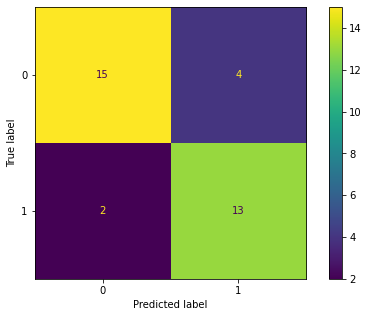

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(100, 3), learning_rate='adaptive',
              max_iter=350, solver='sgd')
Accuracy:  0.8235294117647058
The ROC AUC:  0.8491228070175438



C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


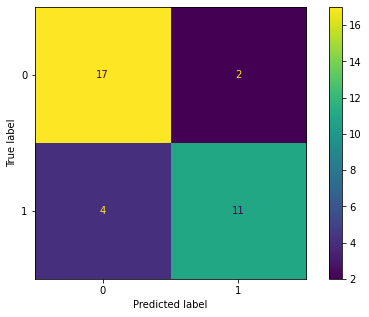

SVC(probability=True)
Accuracy:  0.8529411764705882
The ROC AUC:  0.8912280701754386



C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\ontiv\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


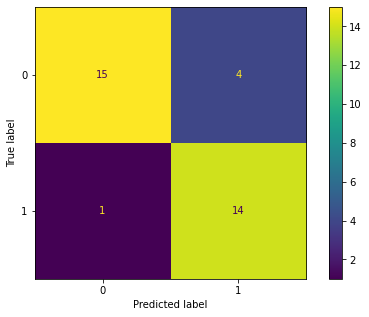

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.810811,0.964286,0.629630,0.711765,0.764706,0.785965
random forest,0.972973,0.995536,0.777778,0.864706,0.794118,0.894737
extra trees,0.972973,1.000000,0.814815,0.935294,0.823529,0.935088
MLP NN,0.567568,0.755952,0.629630,0.547059,0.823529,0.849123
SVM,0.702703,0.910714,0.518519,0.670588,0.852941,0.891228


In [37]:
target = full_appr_ds['depdxever']
dep_results = multi_model(training,target,20,12,'dep')
target = full_appr_ds['anxdxever']
anx_results = multi_model(training,target,20,7,'anx')
target = full_appr_ds['adhd_count']
adhd_results = multi_model(training,target,20,12,'adhd')
master = pd.concat([dep_results,anx_results,adhd_results],axis = 1)
master
# dep_results

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.810811,0.964286,0.629630,0.711765,0.764706,0.785965
random forest,0.972973,0.995536,0.777778,0.864706,0.794118,0.894737
extra trees,0.972973,1.000000,0.814815,0.935294,0.823529,0.935088
MLP NN,0.567568,0.755952,0.629630,0.547059,0.823529,0.849123
SVM,0.702703,0.910714,0.518519,0.670588,0.852941,0.891228


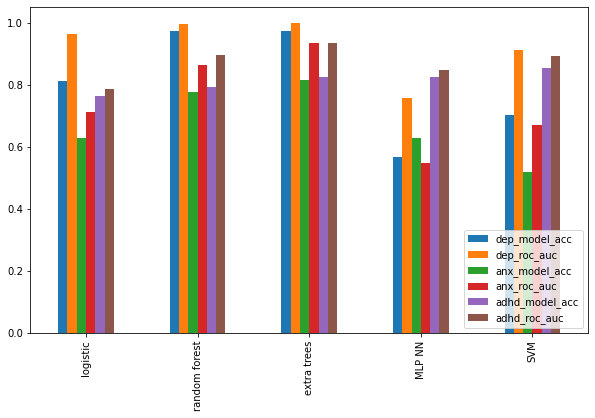

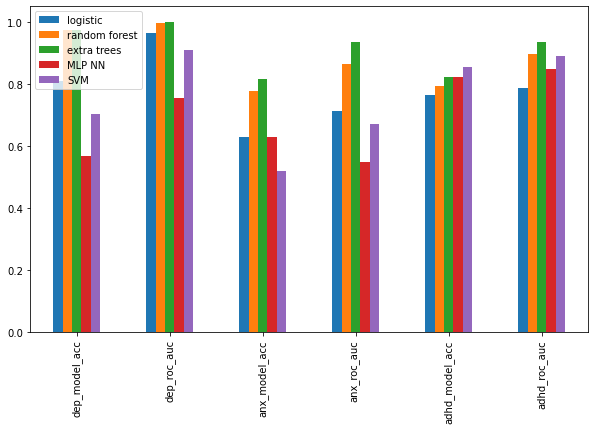

In [38]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd cv  = 12, anx cv = 7, 20 features max, over sampled - SMOTE, minmax scalar
# APPROACH

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.729730,0.777778,0.666667,0.755556,0.676471,0.764912
random forest,0.891892,0.964912,0.629630,0.677778,0.882353,0.959649
extra trees,0.864865,0.976608,0.629630,0.688889,0.852941,0.943860
MLP NN,0.594595,0.619883,0.444444,0.477778,0.411765,0.428070
SVM,0.783784,0.862573,0.629630,0.633333,0.705882,0.835088


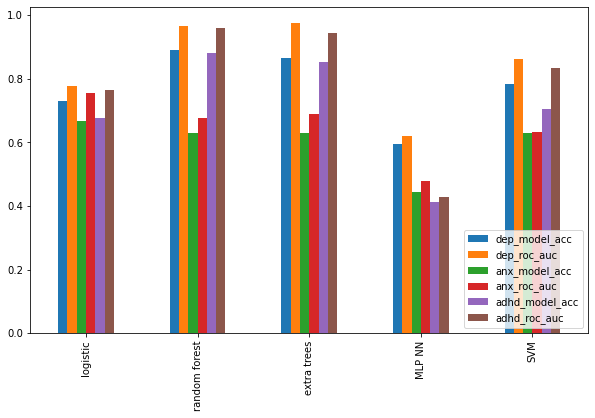

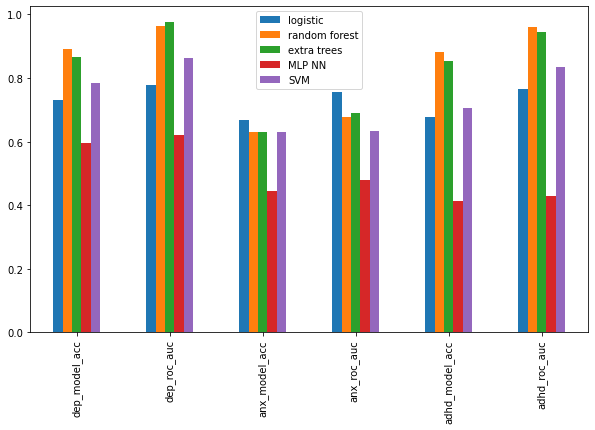

In [33]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd cv  = 12, anx cv = 7, 20 features max, over sampled - SMOTE, minmax scalar
# BUBBLES

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.837838,0.864706,0.481481,0.500000,0.882353,0.940351
random forest,0.783784,0.885294,0.703704,0.681319,0.882353,0.971930
extra trees,0.891892,0.930882,0.629630,0.752747,0.852941,0.975439
MLP NN,0.567568,0.620588,0.481481,0.357143,0.500000,0.480702
SVM,0.918919,0.985294,0.592593,0.703297,0.970588,0.996491


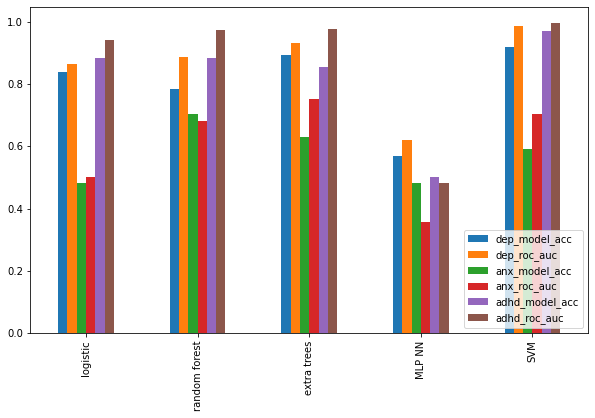

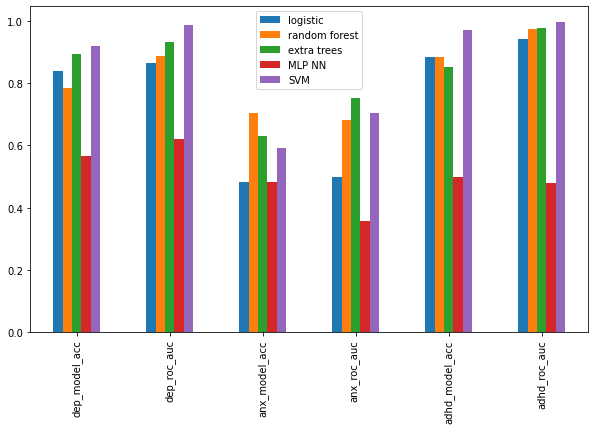

In [24]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd cv  = 12, anx cv = 7, 12 features max, over sampled - SMOTE, minmax scalar
# SPEECH

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.861111,0.869969,0.714286,0.836735,0.857143,0.884868
random forest,0.944444,0.990712,0.750000,0.806122,0.885714,0.894737
extra trees,1.000000,1.000000,0.785714,0.859694,0.885714,0.917763
MLP NN,0.583333,0.659443,0.500000,0.632653,0.400000,0.332237
SVM,1.000000,1.000000,0.714286,0.831633,0.942857,0.934211


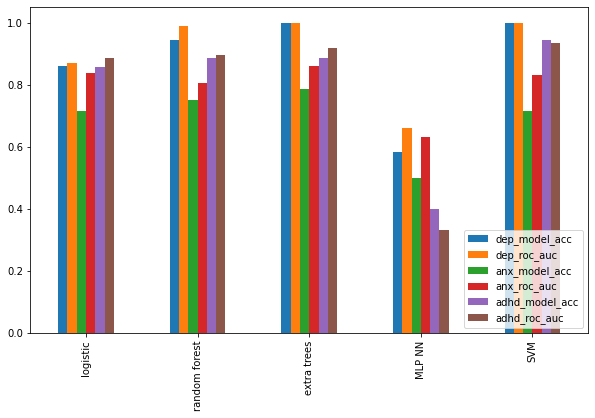

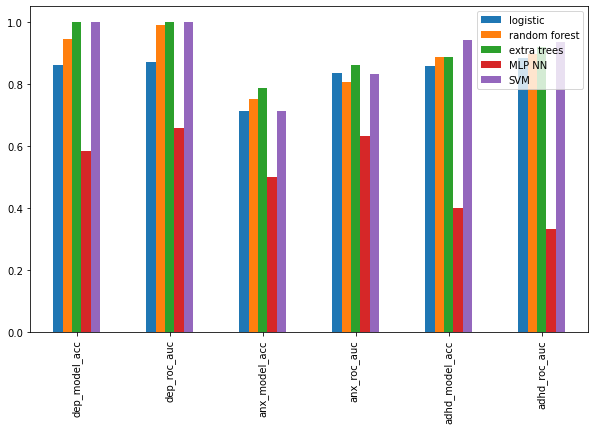

In [9]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd cv  = 12, anx cv = 7, 25 features max, over sampled - ADASYN, minmax scalar
# SPEECH

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.702703,0.779412,0.740741,0.866667,0.823529,0.865052
random forest,0.783784,0.879412,0.703704,0.841667,0.823529,0.913495
extra trees,0.891892,0.950000,0.666667,0.838889,0.911765,0.968858
MLP NN,0.540541,0.405882,0.555556,0.627778,0.470588,0.380623
SVM,0.729730,0.750000,0.555556,0.305556,0.823529,0.910035


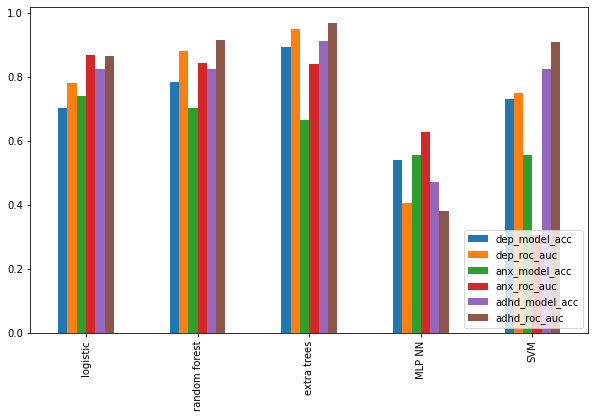

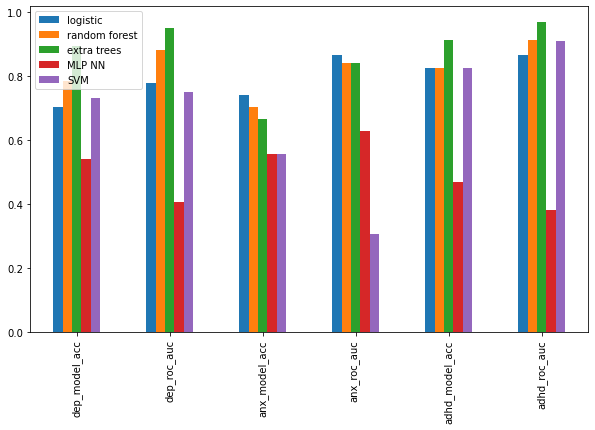

In [22]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd cv  = 12, anx cv = 7, 25 features max, over sampled - SMOTE, minmax scalar
# APPROACHHHHHH

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.945946,0.952941,0.518519,0.637363,0.558824,0.549407
random forest,0.918919,0.985294,0.592593,0.697802,0.676471,0.735178
extra trees,1.000000,1.000000,0.740741,0.741758,0.882353,0.944664
MLP NN,0.513514,0.535294,0.555556,0.516484,0.441176,0.549407
SVM,0.810811,0.894118,0.518519,0.620879,0.735294,0.853755


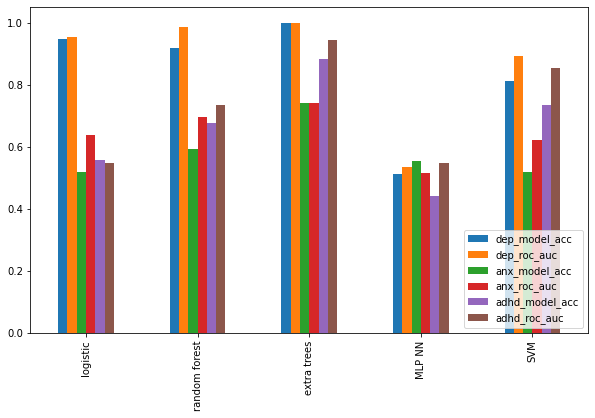

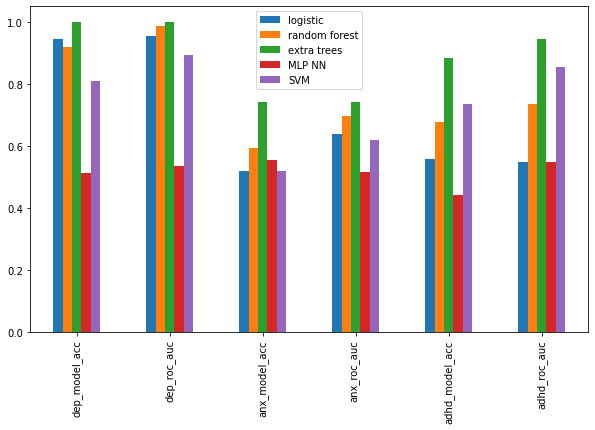

In [17]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd cv  = 12, anx cv = 7, 25 features max, over sampled - SMOTE, minmax scalar
# BUBBLESSSS

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.837838,0.844720,0.629630,0.561111,0.911765,0.851211
random forest,0.945946,0.992236,0.555556,0.644444,0.941176,1.000000
extra trees,0.945946,1.000000,0.555556,0.716667,1.000000,1.000000
MLP NN,0.432432,0.568323,0.444444,0.650000,0.500000,0.307958
SVM,0.837838,0.913043,0.703704,0.769444,0.970588,1.000000


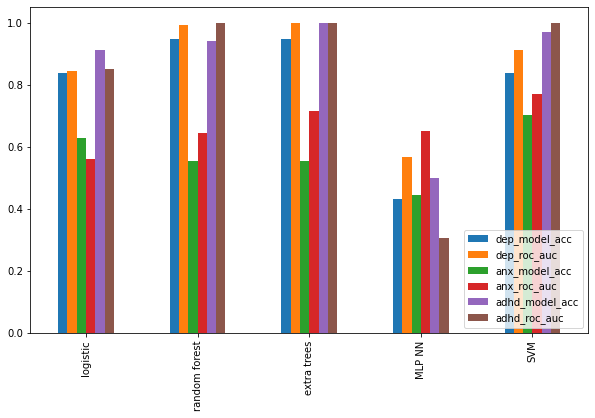

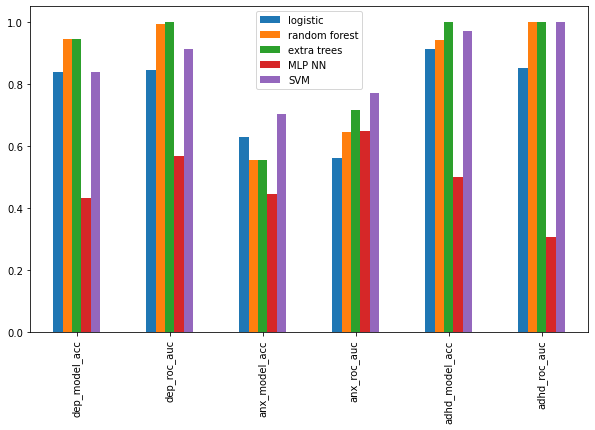

In [9]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
flipped_master = master.T
flipped_master.plot.bar(figsize = (10,6))
master  # # dep & adhd cv  = 12, anx cv = 7, 25 features max, over sampled - SMOTE, minmax scalar

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.918919,0.953216,0.481481,0.586111,0.882353,0.792982
random forest,0.891892,0.960526,0.666667,0.838889,0.823529,0.896491
extra trees,0.972973,0.988304,0.629630,0.844444,0.882353,0.936842
MLP NN,0.513514,0.464912,0.444444,0.438889,0.588235,0.596491
SVM,0.891892,0.988304,0.703704,0.794444,0.823529,0.940351


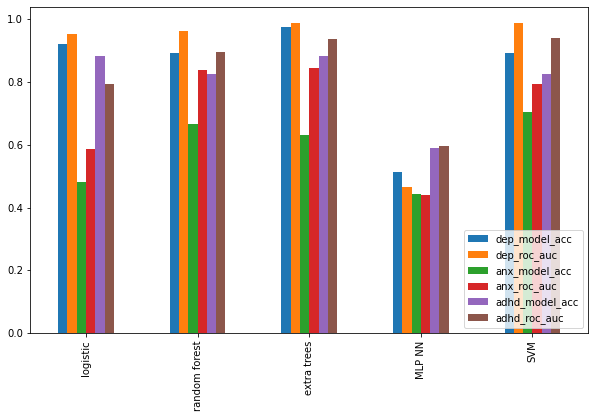

In [54]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
master  # # dep & adhd cv  = 12, anx cv = 7, 25 features max, over sampled - SMOTE, minmax scalar

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.864865,0.869048,0.592593,0.562500,0.911765,0.965398
random forest,0.945946,0.994048,0.629630,0.690341,0.911765,0.986159
extra trees,0.891892,0.955357,0.703704,0.801136,0.911765,0.982699
MLP NN,0.567568,0.562500,0.518519,0.392045,0.617647,0.692042
SVM,0.972973,1.000000,0.629630,0.607955,0.941176,1.000000


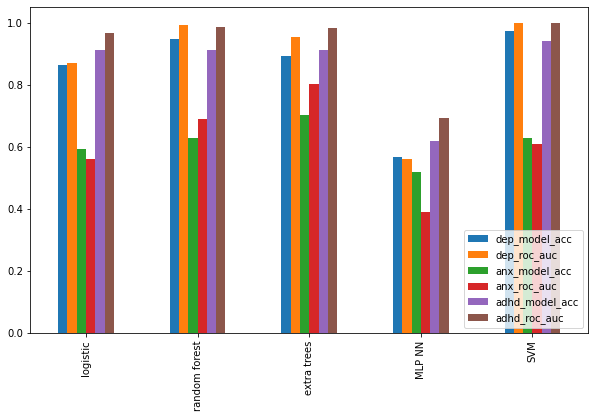

In [43]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
master  # # dep & adhd cv  = 12, anx cv = 7, 25 features, over sampled - SMOTE, minmax scalar

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.837838,0.735294,0.592593,0.554945,0.911765,0.924242
random forest,0.891892,0.930882,0.740741,0.752747,0.911765,0.977273
extra trees,0.918919,0.994118,0.666667,0.829670,0.970588,0.996212
MLP NN,0.405405,0.541176,0.444444,0.423077,0.382353,0.356061
SVM,0.918919,0.994118,0.629630,0.785714,0.970588,1.000000


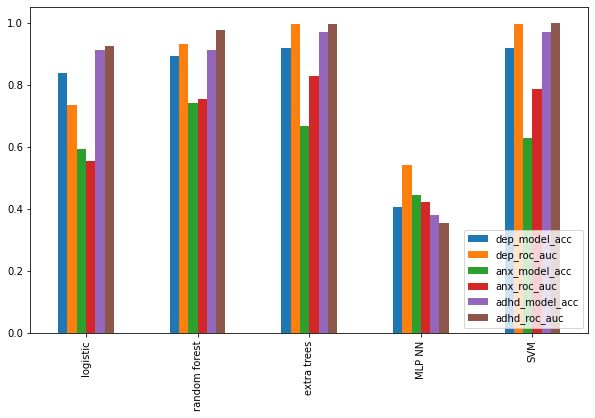

In [37]:
master.plot.bar(figsize=(10, 6))
plt.legend(loc='lower right')
master  # # dep & adhd cv  = 12, anx cv = 7, 25 features, over sampled - SMOTE, minmax scalar

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.864865,0.900298,0.555556,0.638889,0.764706,0.706960
random forest,0.918919,0.965774,0.555556,0.613889,0.647059,0.913919
extra trees,0.972973,0.997024,0.592593,0.647222,0.911765,0.989011
MLP NN,0.567568,0.488095,0.555556,0.444444,0.529412,0.644689
SVM,0.513514,0.363095,0.592593,0.455556,0.411765,0.413919


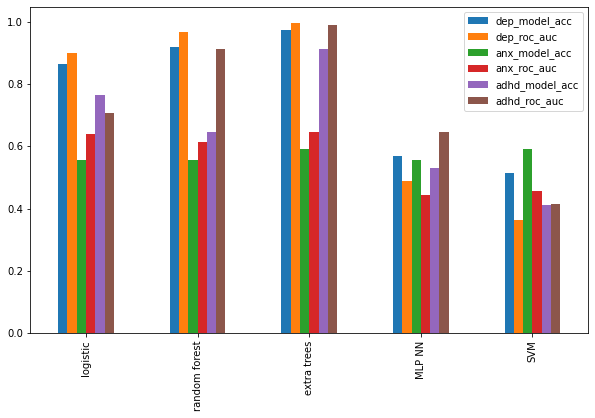

In [7]:
master.plot.bar(figsize=(10, 6))
master  # # dep & adhd cv  = 12, anx cv = 7, 25 features, over sampled - ADASYN

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.918919,0.862179,0.592593,0.604396,0.852941,0.901754
random forest,0.837838,0.910256,0.555556,0.703297,0.617647,0.777193
extra trees,0.891892,0.980769,0.518519,0.612637,0.382353,0.347368
MLP NN,0.405405,0.596154,0.518519,0.467033,0.588235,0.578947
SVM,0.351351,0.288462,0.592593,0.434066,0.441176,0.529825


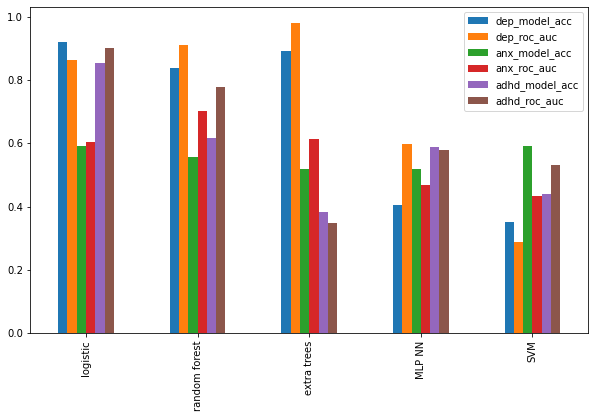

In [35]:
master.plot.bar(figsize=(10, 6))
master  # # dep & adhd cv  = 12, anx cv = 7, 30 features, over sampled - ADASYN

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.861111,0.864198,0.571429,0.523077,0.942857,0.960000
random forest,0.972222,1.000000,0.571429,0.538462,0.942857,0.943333
extra trees,0.972222,0.996914,0.535714,0.579487,0.914286,1.000000
MLP NN,0.527778,0.429012,0.357143,0.292308,0.600000,0.600000
SVM,0.611111,0.402778,0.464286,0.251282,0.571429,0.678333


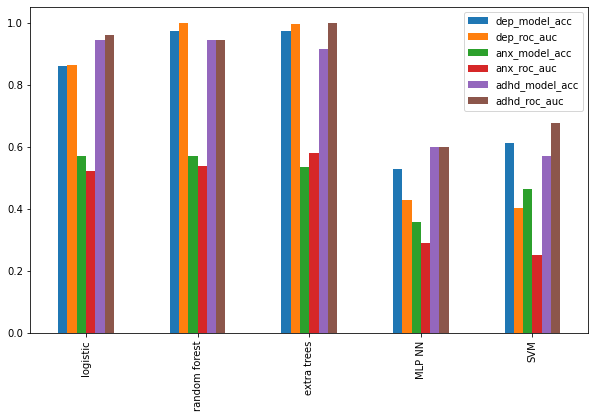

In [32]:
master.plot.bar(figsize=(10, 6))
master  # # dep & adhd cv  = 12, anx cv = 7, 20 features, over sampled - ADASYN

,dep_model_acc,dep_roc_auc,anx_model_acc,anx_roc_auc,adhd_model_acc,adhd_roc_auc
logistic,0.756757,0.706845,0.555556,0.638889,0.794118,0.820513
random forest,0.891892,0.991071,0.555556,0.613889,0.676471,0.893773
extra trees,0.864865,0.962798,0.666667,0.661111,0.941176,0.981685
MLP NN,0.567568,0.488095,0.555556,0.444444,0.529412,0.644689
SVM,0.513514,0.363095,0.592593,0.455556,0.411765,0.413919


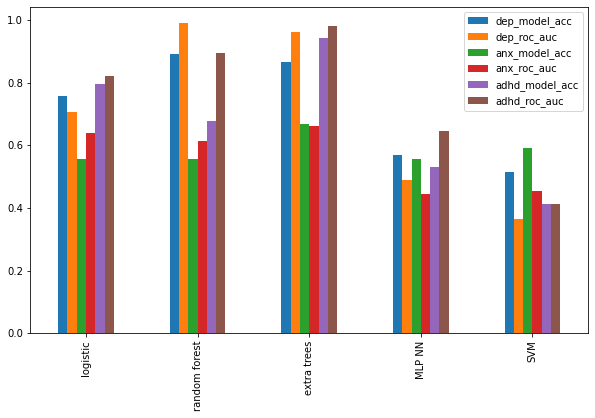

In [22]:
master.plot.bar(figsize=(10, 6))
master  # # dep & adhd cv  = 12, anx cv = 7, 20 features, over sampled - SMOTE

,depmodel_acc,deproc_auc,anxmodel_acc,anxroc_auc,adhdmodel_acc,adhdroc_auc
logistic,0.621622,0.704412,0.444444,0.392045,0.441176,0.485714
random forest,0.783784,0.770588,0.703704,0.690341,0.764706,0.844643
extra trees,0.945946,0.986765,0.703704,0.750000,0.794118,0.894643
MLP NN,0.594595,0.563235,0.407407,0.375000,0.558824,0.550000


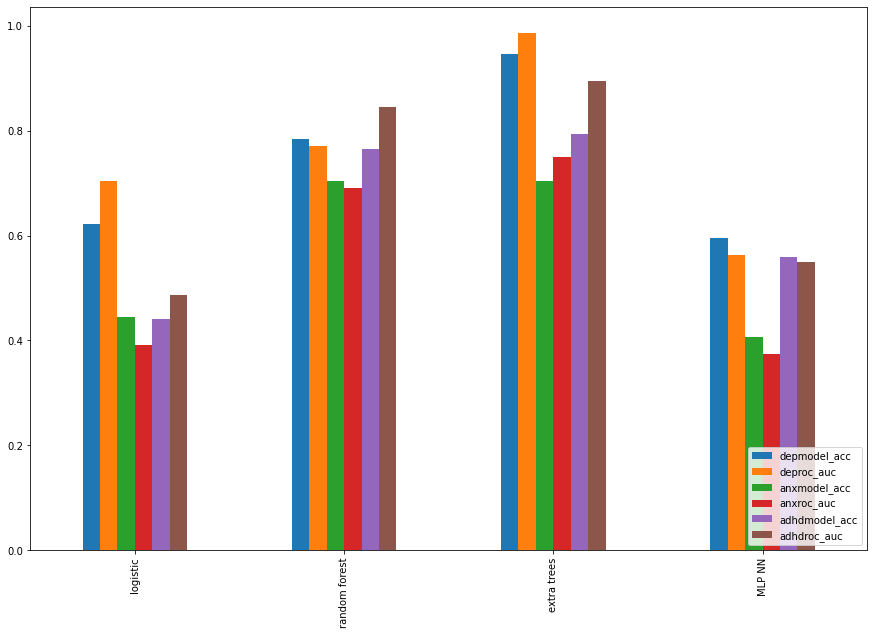

In [47]:
master # dep & adhd cv  = 12, anx cv = 7, 1 features, over sampled
master.plot.bar(figsize=(15, 10))
plt.legend(loc='lower right')
master